In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.metrics import mean_squared_error
from scipy import stats

In [4]:
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.al import top_model as topmodel
from DomainPrediction.al.embeddings import one_hot_encode

2025-01-08 18:36:38.884952: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 18:36:38.887515: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 18:36:38.893268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 18:36:38.904314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 18:36:38.904331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting t

In [5]:
from DomainPrediction.esm.esm2 import ESM2

In [ ]:
sys.path.append('../../esm')
from DomainPrediction.esm.esm3 import ESM3LM
from DomainPrediction.esm.esmc import ESMCLM

#### Load Data

In [6]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/Tdomain'

In [7]:
file = os.path.join(data_path, 'dataset_tdomain.csv')
df = pd.read_csv(file)

In [8]:
df.head()

,name,seq,fitness_raw,split_id,n_mut,fitness_log
0,WT,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,1.000000,2,0,0.000000
1,ESM1,APEDSSFPRPPYAAPEGEIEQTLAGIWMELLGVERVGRHDSFFALG...,0.982485,2,44,-0.017670
2,ESM2,APSEDAYPRATYEAPEGETEQLLAGIWMDLLQVDRVGRHDSFFELG...,0.968661,1,45,-0.031841
3,ESM3,APSEDSYPRPAYVAPEGPTEQLLAGIWQELLNVSKVGRDDSFFDLG...,0.039853,2,46,-3.222547
4,ESM4,APEEASYPREPYVAPQGETEQLLASIWQELLGVERVGAGDNFFELG...,0.457921,2,43,-0.781059


In [9]:
results_file = os.path.join(data_path, 'results_tdomain_zeroshot.csv')

In [10]:
if os.path.isfile(results_file):
    df_results = pd.read_csv(results_file)
else:
    df_results = df.copy()

In [11]:
df_results.head()

,name,seq,fitness_raw,split_id,n_mut,fitness_log,pred_ESM650M_perplexity,pred_ESM3_perplexity,pred_ESMC300M_perplexity,pred_ESMC600M_perplexity
0,WT,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,1.000000,2,0,0.000000,5.838970,5.716982,3.957926,3.351393
1,ESM1,APEDSSFPRPPYAAPEGEIEQTLAGIWMELLGVERVGRHDSFFALG...,0.982485,2,44,-0.017670,4.857078,4.464974,4.347416,3.669246
2,ESM2,APSEDAYPRATYEAPEGETEQLLAGIWMDLLQVDRVGRHDSFFELG...,0.968661,1,45,-0.031841,5.156052,4.475316,3.766888,3.482251
3,ESM3,APSEDSYPRPAYVAPEGPTEQLLAGIWQELLNVSKVGRDDSFFDLG...,0.039853,2,46,-3.222547,5.747274,4.807921,4.690301,4.395126
4,ESM4,APEEASYPREPYVAPQGETEQLLASIWQELLGVERVGAGDNFFELG...,0.457921,2,43,-0.781059,5.075125,4.470202,4.324977,3.690752


In [12]:
df_results.columns[df_results.columns.str.contains('pred')]

Index(['pred_ESM650M_perplexity', 'pred_ESM3_perplexity',
       'pred_ESMC300M_perplexity', 'pred_ESMC600M_perplexity'],
      dtype='object')

In [13]:
len(df_results.columns[df_results.columns.str.contains('pred')])

4

In [14]:
def get_split_mask(df, omit_zero=False):
    if omit_zero:
        train_mask = (df['split_id'] == 2) & (df['fitness_raw'] != 0)
    else:
        train_mask = (df['split_id'] == 2)

    val_mask = df['split_id'] == 1
    test_mask = df['split_id'] == 0

    return train_mask, val_mask, test_mask

#### OHE

In [ ]:
embeddings = one_hot_encode(df['seq'])

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)

X_train = embeddings[train_mask]
X_val = embeddings[val_mask]
X_test = embeddings[test_mask]

# y_train = df.loc[train_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_val = df.loc[val_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_test = df.loc[test_mask, 'fitness_raw'].to_numpy().astype(np.float32)

y_train = df.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [ ]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_OHE_ridge'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_OHE_ridge'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_OHE_ridge'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
surrogate = topmodel.RFSurrogate()
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_OHE_RF'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_OHE_RF'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_OHE_RF'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
print(f'input layer shape: {X_train.shape[1]}')

In [ ]:
config={'layers': [2300, 512, 1], 
        'epoch': 100, 
        'batch_size': 16,
        'patience': 10,
        'early_stopping': False,
        'lr': 1e-3,
        'print_every_n_epoch': 10,
        'debug': True}
surrogate = topmodel.MLPSurrogate(config=config)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_OHE_MLP'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_OHE_MLP'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_OHE_MLP'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ESM2, ESM3 and ESMC Embeddings

In [ ]:
# esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
# esm3 = ESM3LM(device='gpu')
# esmc = ESMCLM(name='esmc_300m', device='gpu')
# esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
# embeddings = esm2.get_embeddings_cls(df['seq'])
# embeddings = esm3.get_embeddings_cls(df['seq'])
# embeddings = esmc.get_embeddings_cls(df['seq'])

In [ ]:
embeddings.shape

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)

X_train = embeddings[train_mask]
X_val = embeddings[val_mask]
X_test = embeddings[test_mask]

# y_train = df.loc[train_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_val = df.loc[val_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_test = df.loc[test_mask, 'fitness_raw'].to_numpy().astype(np.float32)

y_train = df.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [ ]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_ESMC600M_concat_ridge'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_concat_ridge'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_concat_ridge'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
surrogate = topmodel.RFSurrogate()
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_ESMC600M_concat_RF'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_concat_RF'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_concat_RF'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
print(f'input layer shape: {X_train.shape[1]}')

In [ ]:
config={'layers': [1280, 512, 1], 
        'epoch': 500, 
        'batch_size': 16,
        'patience': 500,
        'early_stopping': True,
        'lr': 1e-4,
        'print_every_n_epoch': 10,
        'debug': True}
surrogate = topmodel.MLPSurrogate(config=config)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_ESM650M_cls_MLP'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESM650M_cls_MLP'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESM650M_cls_MLP'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ESM2, ESM3, ESMC - perplexities

In [ ]:
# esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
# esm3 = ESM3LM(device='gpu')
# esmc = ESMCLM(name='esmc_300m', device='gpu')
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
y = df['fitness_log'].to_numpy().astype(np.float32)

In [ ]:
y_pred = []
for seq in tqdm(df['seq']):
    # perplexity = esm2.compute_perplexity(seq)
    # perplexity = esm3.compute_perplexity(seq)
    perplexity = esmc.compute_perplexity(seq)
    y_pred.append(perplexity)

y_pred = np.array(y_pred)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

ax[0].plot(y, -y_pred, '.', alpha=0.5)
mse = mean_squared_error(y, -y_pred)
corr = stats.spearmanr(y, -y_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mask = ~(df['fitness_raw'] == 0)
ax[1].plot(y[mask], -y_pred[mask], '.', alpha=0.5)
mse = mean_squared_error(y[mask], -y_pred[mask])
corr = stats.spearmanr(y[mask], -y_pred[mask])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
assert y_pred.shape[0] == df_results.shape[0]
df_results['pred_ESMC600M_perplexity'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_perplexity'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_perplexity'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [81]:
import torch
import esm
from tqdm import tqdm
import numpy as np


class ESM2():
    def __init__(self, model_path, device='cpu') -> None:
        self.model, self.alphabet = esm.pretrained.load_model_and_alphabet(model_path)
        self.batch_converter = self.alphabet.get_batch_converter()
        self.model.eval()
        self.device = device

        if 't6_8M' in model_path:
            self.rep_layer = 6
            self.emb_dim = 320
        elif 't30_150M' in model_path:
            self.rep_layer = 30
            self.emb_dim = 640
        elif 't33_650M' in model_path:
            self.rep_layer = 33
            self.emb_dim = 1280
        else:
            raise Exception('I need to work on this. Feel free to extend :)')

        if self.device == 'gpu':
            self.model.cuda()

        self.tok_to_idx = self.alphabet.tok_to_idx
        self.idx_to_tok = {v:k for k,v in self.tok_to_idx.items()}

    def get_res(self, sequence, rep_layer=None):
        if rep_layer is None:
            rep_layer = self.rep_layer

        data = [
            ("protein1", sequence)
        ]
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

        if self.device == 'gpu':
            batch_tokens = batch_tokens.cuda()

        with torch.no_grad():
            results = self.model(batch_tokens, repr_layers=[rep_layer], return_contacts=True)

        return results

    def get_res_batch(self, sequences, rep_layer=None):
        if rep_layer is None:
            rep_layer = self.rep_layer

        data = [
            (f"P{i+1}", seq) for i, seq in enumerate(sequences)
        ]
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

        if self.device == 'gpu':
            batch_tokens = batch_tokens.cuda()

        with torch.no_grad():
            results = self.model(batch_tokens, repr_layers=[rep_layer], return_contacts=True)

        return results, batch_lens

    def get_logits(self, sequence):

        results = self.get_res(sequence)
        return results['logits']

    def get_prob(self, sequence):
        logits = self.get_logits(sequence)
        prob = torch.nn.functional.softmax(logits, dim=-1)[0, 1:-1, :] # 1st and last are start and end tokens

        return prob.cpu().numpy()
    
    def get_embeddings_mean(self, sequences):
        embeddings = []
        for seq in tqdm(sequences):
            rep = self.get_res(sequence=seq)
            embeddings.append(rep['representations'][self.rep_layer][:,1:-1,:].mean(1).cpu().numpy())

        embeddings = np.concatenate(embeddings, axis=0)

        return embeddings
    
    def get_embeddings_flatten(self, sequences):
        embeddings = []
        for seq in tqdm(sequences):
            rep = self.get_res(sequence=seq)
            embeddings.append(rep['representations'][self.rep_layer][:,1:-1,:].cpu().numpy()[0].flatten())

        embeddings = np.stack(embeddings, axis=0)

        return embeddings
    
    def __get_embeddings_full(self, sequences):
        embeddings = []
        for seq in tqdm(sequences):
            rep = self.get_res(sequence=seq)
            embeddings.append(rep['representations'][self.rep_layer][:,1:-1,:].cpu().numpy()[0])

        return embeddings
    
    def get_embeddings_cls(self, sequences):
        embeddings = []
        for seq in tqdm(sequences):
            rep = self.get_res(sequence=seq)
            embeddings.append(rep['representations'][self.rep_layer][:, 0, :].cpu().numpy())

        embeddings = np.concatenate(embeddings, axis=0)

        return embeddings
    
    def get_embeddings_feature_pool(self, sequences, pool='mean'):
        embeddings = []
        for seq in tqdm(sequences):
            rep = self.get_res(sequence=seq)
            if pool == 'mean':
                embeddings.append(rep['representations'][self.rep_layer][:,1:-1,:].mean(-1).cpu().numpy())
            elif pool == 'sum':
                embeddings.append(rep['representations'][self.rep_layer][:,1:-1,:].sum(-1).cpu().numpy())
            else:
                raise Exception('pool can only take values mean or sum')
            
        embeddings = np.concatenate(embeddings, axis=0)

        return embeddings
    
    def compute_perplexity(self, sequence, mask_token='<mask>'):
        '''
            pseudoperplexity(x) = exp( -1/L \sum_{i=1}_{L} [log( p(x_{i}|x_{j!=i}) )] )
            
        '''
        
        sum_log = 0
        for pos in range(len(sequence)):
            masked_query = list(sequence)
            assert mask_token not in masked_query
            masked_query[pos] = mask_token
            masked_query = ''.join(masked_query)
            prob = self.get_prob(sequence=masked_query)

            assert prob.shape[0] == len(sequence)

            prob_pos = np.log(prob[pos, self.tok_to_idx[sequence[pos]]])
            
            sum_log += prob_pos

        return np.exp(-1*sum_log/len(sequence))
    
    def get_log_prob(self, sequence):
        logits = self.get_logits(sequence)
        log_prob = torch.log_softmax(logits, dim=-1)[0,1:-1,:]

        return log_prob.cpu().numpy()
    
    def get_wildtype_marginal(self, mt_sequence, wt_sequence, wt_log_prob=None):
        if wt_log_prob is None:
            assert len(wt_sequence) == len(mt_sequence)
            wt_log_prob = self.get_log_prob(sequence=wt_sequence)

        assert wt_log_prob.shape[0] == len(wt_sequence) == len(mt_sequence)

        n_muts = 0
        score = 0
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos
                n_muts += 1

                idx_mt = self.tok_to_idx[aa_mt]
                idx_wt = self.tok_to_idx[aa_wt]
                score += wt_log_prob[i, idx_mt] - wt_log_prob[i, idx_wt]


        return score, n_muts

In [82]:
esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')

In [83]:
wt_sequence = df.loc[df['name'] == 'WT', 'seq'].iloc[0]

['<eos>', '<unk>', '<pad>', '<cls>', '<mask>']

In [105]:
def get_masked_marginal(mt_sequence, wt_sequence, mask_token = '<mask>'):
        # if wt_log_prob is None:
        #     assert len(wt_sequence) == len(mt_sequence)
        #     wt_log_prob = self.get_log_prob(sequence=wt_sequence)

        assert len(wt_sequence) == len(mt_sequence)

        n_muts = 0
        mask_positions = []
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos
                n_muts += 1
                mask_positions.append(i)

        assert len(mask_positions) == n_muts
        masked_query = list(wt_sequence)
        for _pos in mask_positions:
            masked_query[_pos] = mask_token
        masked_sequence = ''.join(masked_query)

        masked_log_prob = esm2.get_log_prob(sequence=masked_sequence)
        
        score = 0
        _idx = 0
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos

                assert mask_positions[_idx] == i
                _idx += 1

                idx_mt = esm2.tok_to_idx[aa_mt]
                idx_wt = esm2.tok_to_idx[aa_wt]
                score += masked_log_prob[i, idx_mt] - masked_log_prob[i, idx_wt]


        return score, n_muts

In [106]:
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    score, n_muts = get_masked_marginal(mt_sequence, wt_sequence)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)

In [69]:
wt_log_prob = esm2.get_log_prob(wt_sequence)
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    score, n_muts = esm2.get_wildtype_marginal(mt_sequence, wt_sequence, wt_log_prob)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)

78it [00:00, 25615.07it/s]


In [107]:
y = df['fitness_log'].to_numpy().astype(np.float32)

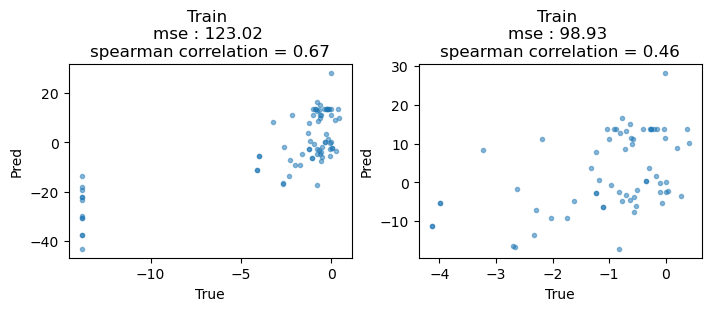

In [108]:
fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

ax[0].plot(y, y_pred, '.', alpha=0.5)
mse = mean_squared_error(y, y_pred)
corr = stats.spearmanr(y, y_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mask = ~(df['fitness_raw'] == 0)
ax[1].plot(y[mask], y_pred[mask], '.', alpha=0.5)
mse = mean_squared_error(y[mask], y_pred[mask])
corr = stats.spearmanr(y[mask], y_pred[mask])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

<Axes: >

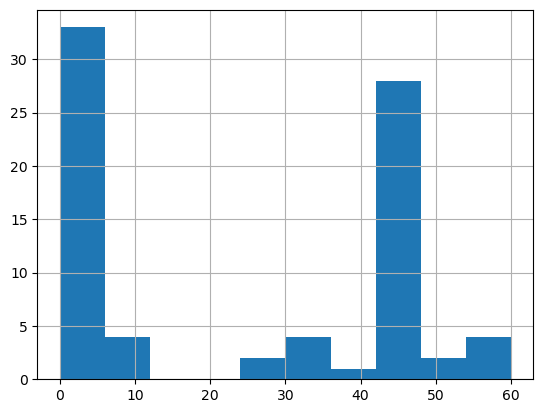

In [109]:
df['n_mut'].hist()

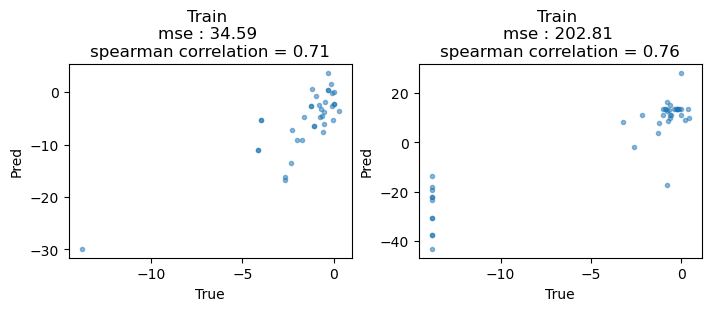

In [112]:
fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

mask_muts = (df['n_mut'] < 20)

ax[0].plot(y[mask_muts], y_pred[mask_muts], '.', alpha=0.5)
mse = mean_squared_error(y[mask_muts], y_pred[mask_muts])
corr = stats.spearmanr(y[mask_muts], y_pred[mask_muts])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

# mask = ~(df['fitness_raw'] == 0)
ax[1].plot(y[~mask_muts], y_pred[~mask_muts], '.', alpha=0.5)
mse = mean_squared_error(y[~mask_muts], y_pred[~mask_muts])
corr = stats.spearmanr(y[~mask_muts], y_pred[~mask_muts])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

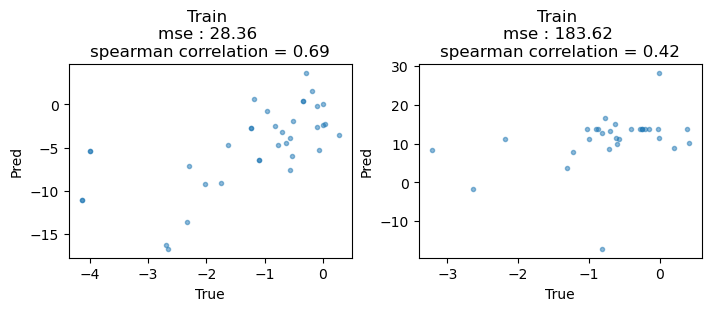

In [113]:
fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

mask_muts = (df['n_mut'] < 20)
mask_omit = ~(df['fitness_raw'] == 0)

ax[0].plot(y[mask_muts & mask_omit], y_pred[mask_muts & mask_omit], '.', alpha=0.5)
mse = mean_squared_error(y[mask_muts & mask_omit], y_pred[mask_muts & mask_omit])
corr = stats.spearmanr(y[mask_muts & mask_omit], y_pred[mask_muts & mask_omit])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

ax[1].plot(y[~mask_muts & mask_omit], y_pred[~mask_muts & mask_omit], '.', alpha=0.5)
mse = mean_squared_error(y[~mask_muts & mask_omit], y_pred[~mask_muts & mask_omit])
corr = stats.spearmanr(y[~mask_muts & mask_omit], y_pred[~mask_muts & mask_omit])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()